In [1]:
!pip install torch torchvision timm retina-face opencv-python matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import timm
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from retinaface import RetinaFace
from scipy.spatial.distance import cosine

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ghostnet = timm.create_model("ghostnet_100", pretrained=True, num_classes=512)
ghostnet = ghostnet.to(device)
ghostnet.eval()

model.safetensors:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

GhostNet(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): GhostBottleneck(
        (ghost1): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (cheap_operation): Sequential(
            (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
        )
        (ghost2): GhostModule(
          (primary_conv): Sequential(
            (0): Conv2d(16, 8, kernel_size=(1, 1)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_ghostnet_embedding(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = ghostnet(image).cpu().numpy().flatten()
    return embedding

In [5]:
faces_dir = "/content/faces/"
uploaded_faces = {}
uploaded_embeddings = {}

for filename in os.listdir(faces_dir):
    img_path = os.path.join(faces_dir, filename)
    img = Image.open(img_path).convert("RGB")

    ghostnet_embedding = get_ghostnet_embedding(img)

    uploaded_faces[filename] = img
    uploaded_embeddings[filename] = ghostnet_embedding


In [6]:
group_img_path = "/content/DSCF3076.JPG"
group_img = Image.open(group_img_path).convert("RGB")

group_img_cv = cv2.imread(group_img_path)
group_img_rgb = cv2.cvtColor(group_img_cv, cv2.COLOR_BGR2RGB)
faces = RetinaFace.detect_faces(group_img_path)

group_boxes = []
group_embeddings = []

for key in faces.keys():
    identity = faces[key]
    x, y, w, h = identity["facial_area"]
    face_crop = group_img.crop((x, y, x+w, y+h))

    ghostnet_embedding = get_ghostnet_embedding(face_crop)

    group_boxes.append((x, y, w, h))
    group_embeddings.append(ghostnet_embedding)

25-03-05 09:28:19 - Directory /root/.deepface created
25-03-05 09:28:19 - Directory /root/.deepface/weights created
25-03-05 09:28:19 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 94.9MB/s]


In [7]:
threshold = 0.5
face_matching_results = {}

for person, uploaded_emb in uploaded_embeddings.items():
    best_match = "Not Found"
    best_score = float("inf")

    for idx, group_emb in enumerate(group_embeddings):
        score = cosine(uploaded_emb, group_emb)
        if score < threshold and score < best_score:
            best_match = idx
            best_score = score

    face_matching_results[person] = best_match

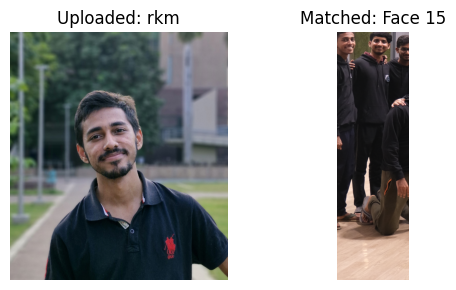

In [10]:
num_matches = sum(1 for v in face_matching_results.values() if v != "Not Found")

fig, axes = plt.subplots(num_matches, 2, figsize=(6, num_matches * 3))

if num_matches == 1:
    axes = [axes]  # Convert single-row axes to a list for consistent indexing

row_idx = 0

for person in uploaded_faces.keys():
    matched_idx = face_matching_results[person]

    if matched_idx != "Not Found":
        uploaded_face_path = os.path.join(faces_dir, person)
        uploaded_face = Image.open(uploaded_face_path).convert("RGB")

        x, y, w, h = group_boxes[matched_idx]
        matched_face = group_img.crop((x, y, x+w, y+h))

        axes[row_idx][0].imshow(uploaded_face)
        axes[row_idx][0].axis("off")
        axes[row_idx][0].set_title(f"Uploaded: {person.split('.')[0]}")

        axes[row_idx][1].imshow(matched_face)
        axes[row_idx][1].axis("off")
        axes[row_idx][1].set_title(f"Matched: Face {matched_idx + 1}")

        row_idx += 1

plt.tight_layout()
plt.show()